# From Intake to Outcome: Analyzing the Austin Animal Center's Intake and Outcomes Datasets

The [Austin Animal Center](http://www.austintexas.gov/department/aac) provides its [animal intake](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) and [outcome datasets](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238) on [Socrata](https://socrata.com/). When an animal is taken into the shelter, it is given a unique identifier that is also used in the outcomes dataset. We have already investigated and performed exploratory data analysis on the [Austin Animal Center's intakes](https://aaronschlegel.me/austin-animal-center-intakes-exploratory-data-analysis-python-pandas-seaborn.html) and [animal outcomes](https://aaronschlegel.me/exploratory-data-analysis-shelter-cat-outcomes-pandas-seaborn.html) individually and found several interesting facets of information. In this analysis, we merge the intakes and outcomes dataset using [pandas](https://pandas.pydata.org/) to enable us to perform exploratory data analysis on the merged data. With the data merged, we will be able to explore in more depth the transition from intake to outcome.

## Getting Started

As before, we import the libraries that will be used throughout the analysis. The [`%matplotlib inline`](http://ipython.readthedocs.io/en/stable/interactive/plotting.html) is used for displaying the visualizations.

In [1]:
%matplotlib inline

import requests
import pandas as pd
import numpy as np
import seaborn as sns
from urllib.error import HTTPError
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

The following imports a Python module containing the `get_soda_api_data()` function and the other transformation function used in the intakes analysis. The code can be found as a [Github Gist](https://gist.github.com/aschleg/10b2c68953c119a734c247edee5b3049).

In [2]:
import aac_analysis as aac

## Getting the Data

As seen in previous analyses, the Austin Animal Center datasets are hosted on the Socrata Open Data Access (SODA) API. We've already extracted the intakes dataset in the most recent analysis. Therefore, we only need to extract the outcomes data using the SODA API. We extract the AAC outcomes dataset using the `get_soda_api_data()` function from the `aac_analysis` module. 

In [3]:
outcomes_endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'

outcomes_df = aac.get_soda_api_data(outcomes_endpoint)

Print the dimensions of the extracted data and the first five rows.

In [4]:
print(outcomes_df.shape)
outcomes_df.head()

(80681, 12)


,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


There are slightly more than 80k rows and 12 columns, which match the metadata available on the outcomes data page on Socrata (at the time of this writing). Now that we have the data extracted from the SODA API and converted into a pandas DataFrame let's save the data as a CSV file to avoid the need to call the Socrata API more times than necessary.

In [5]:
outcomes_df.to_csv('../../../datasets/austin animal center intake outcomes/aac_outcomes.csv', 
                   encoding='utf-8', index=False)

## Creating and preparing the merged dataset

Now that we have the outcomes dataset, we begin adding more features to the data similarly to the intakes. As we have already created the necessary functions during the intakes analysis, this step is merely a matter of applying the functions to the data. Before that, however, we create another function for adding more features related to the animal's estimated date of birth, which is provided in the outcomes data but not the intakes.

In [6]:
def transform_birthdates(df):
    df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])

    df['dob_year'] = df['date_of_birth'].dt.year
    df['dob_month'] = df['date_of_birth'].dt.month
    df['dob_monthyear'] = pd.to_datetime(df['monthyear']).dt.to_period('M')

    return df

We now add more features to the outcomes using our previously developed functions and the newly written `transform_birthdates()` function. 

In [7]:
outcomes_df = aac.transform_age(outcomes_df, 'age_upon_outcome')
outcomes_df = aac.transform_date(outcomes_df, 'outcome')
outcomes_df = aac.create_unique_id(outcomes_df, 'outcome')
outcomes_df = transform_birthdates(outcomes_df)

outcomes_df.head()

,index,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,...,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,animal_id_new,dob_year,dob_month,dob_monthyear
0,0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,...,7,2014,2014-07,Tuesday,16,1.0,A684346_1,2014,7,2014-07
1,1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,...,11,2013,2013-11,Thursday,11,1.0,A666430_1,2012,11,2013-11
2,2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,...,6,2014,2014-06,Tuesday,14,1.0,A675708_1,2013,3,2014-06
3,3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,...,6,2014,2014-06,Sunday,15,1.0,A680386_1,2005,6,2014-06
4,4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,...,7,2014,2014-07,Monday,14,1.0,A683115_1,2014,1,2014-07


The additional feature columns are now added to the outcomes data! The last step in creating the dataset is to load the intakes data we previously worked with and merge the two sets. We load the intakes data that was saved at the end of the analysis with all the added features already included using pandas's [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html).

In [8]:
intakes_df = pd.read_csv('../../../datasets/austin animal center intake outcomes/aac_intakes_transformed.csv')

Both datasets are now loaded as DataFrames. Before proceeding to merge the data, we take an additional step of dropping the duplicate columns in both datasets. First, let's check to see what and how many duplicate columns are in both datasets.

In [9]:
set(intakes_df.columns).intersection(outcomes_df.columns)

{'animal_id',
 'animal_id_new',
 'animal_type',
 'breed',
 'color',
 'index',
 'name'}

We want to keep some of the columns like `breed` and `color` in one dataset, but drop the duplicate and no longer needed columns in the other dataset. We choose to keep the still relevant columns in the outcomes dataset, not for any particular reason as the values should be the same across the data. One could investigate further and see if the animal's descriptive values like `color` change from intake to outcome are indeed true, but this isn't germane to our particular analysis.

In [10]:
cols_to_drop = ['index', 'name']

outcomes_df.drop(['animal_type', 'breed', 'color'] + cols_to_drop, axis=1, inplace=True)
intakes_df.drop(cols_to_drop, axis=1, inplace=True)

The unneeded and duplicate columns are now removed from the datasets. Therefore, we can proceed to merge the data! The unique identifier we created using the provided animal's id and intake and outcome number is set as the index for both datasets. This unique id allows us to perform the merge appropriately as some of the animal IDs in both datasets are not unique, due to some animals being taken into the shelter on multiple occasions. The merge itself is performed using pandas's [`merge`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) function, which merges two DataFrames by using a SQL-style join.

In [11]:
outcomes_df.set_index('animal_id_new', inplace=True)
intakes_df.set_index('animal_id_new', inplace=True)

in_out = pd.merge(outcomes_df, intakes_df, how='inner', 
                  right_index=True, left_index=True, suffixes=['_outcome', '_intake'])

Let's check the columns of the new dataset along with the dimensions and the first few rows of the data.

In [12]:
print(in_out.columns)
print(in_out.shape)
in_out.head()

Index(['age_upon_outcome', 'animal_id_outcome', 'date_of_birth', 'datetime',
       'monthyear', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome',
       'age_upon_outcome_Periods', 'age_upon_outcome_Period Range',
       'age_upon_outcome_(days)', 'age_upon_outcome_(years)',
       'age_upon_outcome_age_group', 'outcome_datetime', 'outcome_month',
       'outcome_year', 'outcome_monthyear', 'outcome_weekday', 'outcome_hour',
       'outcome_number', 'dob_year', 'dob_month', 'dob_monthyear',
       'Unnamed: 0', 'age_upon_intake', 'animal_id_intake', 'animal_type',
       'breed', 'color', 'found_location', 'intake_condition', 'intake_type',
       'sex_upon_intake', 'count', 'age_upon_intake_(days)',
       'age_upon_intake_(years)', 'age_upon_intake_age_group',
       'intake_datetime', 'intake_month', 'intake_year', 'intake_monthyear',
       'intake_weekday', 'intake_hour', 'intake_number'],
      dtype='object')
(79681, 44)


,age_upon_outcome,animal_id_outcome,date_of_birth,datetime,monthyear,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_Periods,age_upon_outcome_Period Range,...,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number
animal_id_new,,,,,,,,,,,,,,,,,,,,,
A006100_1,10 years,A006100,2007-07-09,2017-12-07T00:00:00,2017-12-07T00:00:00,NaN,Return to Owner,Neutered Male,10,365,...,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,2017,2017-12,Thursday,14,1.0
A006100_2,7 years,A006100,2007-07-09,2014-12-20T16:35:00,2014-12-20T16:35:00,NaN,Return to Owner,Neutered Male,7,365,...,2555,7.0,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0
A006100_3,6 years,A006100,2007-07-09,2014-03-08T17:10:00,2014-03-08T17:10:00,NaN,Return to Owner,Neutered Male,6,365,...,2190,6.0,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0
A047759_1,10 years,A047759,2004-04-02,2014-04-07T15:12:00,2014-04-07T15:12:00,Partner,Transfer,Neutered Male,10,365,...,3650,10.0,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0
A134067_1,16 years,A134067,1997-10-16,2013-11-16T11:54:00,2013-11-16T11:54:00,NaN,Return to Owner,Neutered Male,16,365,...,5840,16.0,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0


With one merged dataset that contains the available data of an animal's intake to outcome, we can find the amount of time the animal was in the shelter before its outcome. The intake and outcome datetimes are converted into datetime objects using pandas's [`to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) function. We can then subtract the times to create a `time_in_shelter` column. 

In [13]:
in_out['outcome_datetime'] = pd.to_datetime(in_out['outcome_datetime'])
in_out['intake_datetime'] = pd.to_datetime(in_out['intake_datetime'])

in_out['time_in_shelter'] = in_out['outcome_datetime'] - in_out['intake_datetime']

Using the [`describe()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html) method, we can get a handy table of descriptive statistics that gives us a general sense of the distribution of the newly created `time_in_shelter` column.

In [14]:
in_out['time_in_shelter'].describe()

count                      79681
mean     15 days 18:25:09.054856
std      42 days 01:29:31.408129
min         -1607 days +19:20:00
25%              1 days 02:09:00
50%              4 days 23:20:00
75%             13 days 05:21:00
max           1101 days 18:49:00
Name: time_in_shelter, dtype: object

Interestingly, the minimum time an animal was in the shelter is $-1,607$ days, which is obviously not a real value. Having a negative number of days in the shelter would imply a number of the intake datetimes are more recent than their respective outcome datetimes. To investigate a little further, we can filter the dataset for intake datetimes that are more recent than their outcomes.

In [15]:
in_later = in_out[['intake_datetime', 'outcome_datetime']][in_out['intake_datetime'] > in_out['outcome_datetime']]

print(len(in_later))
in_later.head()

502


,intake_datetime,outcome_datetime
animal_id_new,,
A006100_1,2017-12-07 14:07:00,2017-12-07 00:00:00
A531317_1,2017-09-19 13:59:00,2017-09-17 05:55:00
A531969_1,2015-11-13 12:18:00,2015-11-13 00:00:00
A533243_2,2016-12-20 16:50:00,2016-12-20 00:00:00
A554047_2,2016-05-26 16:33:00,2016-05-26 00:00:00


The length of the filtered data indicates there are just over 500 records that have a more recent intake than outcome. As there are just under 80,000 rows in the entire dataset, it is likely the incorrect datetimes are merely a matter of the data being entered incorrectly. Assuming the intake and outcome dates are switched, we can correct the datetimes by replacing the values when the intake is more recent than the outcome.

In [16]:
in_out['intake_datetime'], in_out['outcome_datetime'] = np.where(in_out['intake_datetime'] > in_out['outcome_datetime'],
                                                                [in_out['outcome_datetime'], in_out['intake_datetime']],
                                                                [in_out['intake_datetime'], in_out['outcome_datetime']])

We can now update the `time_in_shelter` column using the corrected dates and print the descriptive statistics table to see if the distribution is more in-line with reality.

In [17]:
in_out['time_in_shelter'] = pd.to_datetime(in_out['outcome_datetime']) - pd.to_datetime(in_out['intake_datetime'])
in_out['time_in_shelter'].describe()

count                      79681
mean     16 days 18:11:31.584693
std      41 days 16:15:29.702896
min              0 days 00:00:00
25%              1 days 02:28:00
50%              4 days 23:42:00
75%             13 days 15:51:00
max           1606 days 04:40:00
Name: time_in_shelter, dtype: object

Much better! We see the mean number of days from intake to outcome is just over two weeks, and about 50% of the animals incoming to the shelter will remain there for less than five days. The most prolonged stay in the shelter is 1,606 days or just under 4.5 years. To double-check that the intake and outcome dates are adjusted, we can filter the dataset again as before. If there are no intake dates that are more recent than the outcome, the returned DataFrame should be empty.

In [18]:
in_out[['intake_datetime', 'outcome_datetime']][in_out['intake_datetime'] > in_out['outcome_datetime']]

,intake_datetime,outcome_datetime
animal_id_new,,


The filtered DataFrame is indeed empty! Now that we have merged the intakes and outcomes datasets and cleaned and transformed the data, we can proceed to perform exploratory data analysis! Before moving to the next step, let's quickly remove some of the no longer needed columns left over from the merge and save the data to a CSV.

In [19]:
del in_out['Unnamed: 0']
del in_out['monthyear']
del in_out['age_upon_outcome_Periods']
del in_out['age_upon_outcome_Period Range']
del in_out['datetime']

in_out.to_csv('../../../datasets/austin animal center intake outcomes/aac_intakes_outcomes.csv', 
              encoding='utf-8', index=False)

## Analyzing animals' journey from intake to outcome

Now we're in the heat of the meat! The exploratory data analysis we perform here will be instrumental in later steps when constructing prediction models as we will already have an understanding of what variables are seemingly crucial in determining the animals' length of stay at the shelter or outcome type. Before diving in, we quickly set some default styles for the plots that will be created with [seaborn](https://seaborn.pydata.org/) using [`set`](https://seaborn.pydata.org/generated/seaborn.set.html).

In [20]:
sns.set(style="white", context="talk", font_scale=1.2)

To start, let's get a sense of the distribution of animal types that are included in the data using [`value_counts`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html).

In [21]:
in_out['animal_type'].value_counts()

Dog          45366
Cat          29539
Other         4428
Bird           339
Livestock        9
Name: animal_type, dtype: int64

As one might have reasonably assumed, the majority of animals taken into the shelter are cats and dogs. Unfortunately, there is no information regarding what entails the `Other` category, while birds and livestock are taken into the shelter rather rarely in comparison. There are only nine livestock records, which is rather low for our analysis and also not as much of interest. Therefore we filter out these records with [`.loc`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html).

In [22]:
in_out = in_out.loc[in_out['animal_type'] != 'Livestock']

Let's investigate the mean duration an animal stays at the shelter until its outcome based on the animal's age group and type. Before plotting, we create a new column that is the float representation of the `time_in_shelter` column, which has a [`timedelta`](https://docs.python.org/3/library/datetime.html#timedelta-objects) data type. This conversion can be done by accessing the `total_seconds()` method of the `dt` attribute and dividing it by the number of seconds in one day.

In [23]:
in_out['time_in_shelter'] = pd.to_timedelta(in_out['time_in_shelter'])
in_out['time_in_shelter_days'] = in_out['time_in_shelter'].dt.total_seconds() / (24 * 60 * 60)

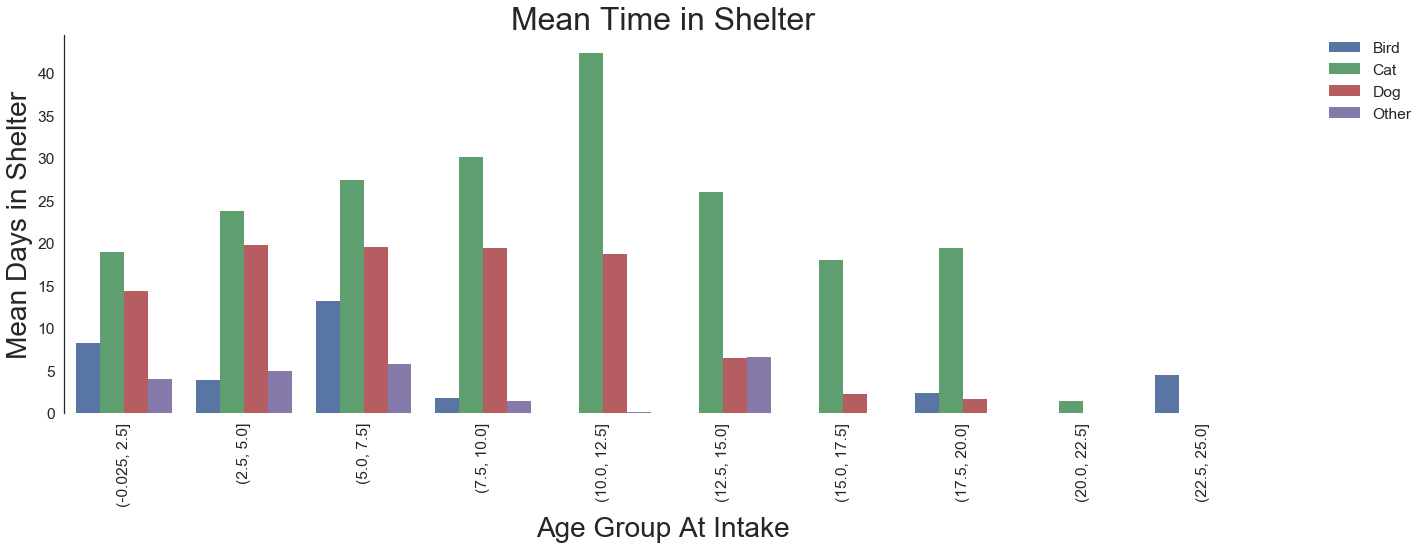

In [24]:
animal_shelter_time = in_out.groupby(['animal_type', 
                                      'age_upon_intake_age_group'])['time_in_shelter_days'].mean().reset_index()

bar = sns.barplot(x='age_upon_intake_age_group', y='time_in_shelter_days', 
                  hue='animal_type', data=animal_shelter_time, order=['(-0.025, 2.5]', '(2.5, 5.0]', '(5.0, 7.5]', 
                                                                     '(7.5, 10.0]', '(10.0, 12.5]', '(12.5, 15.0]', 
                                                                     '(15.0, 17.5]', '(17.5, 20.0]', '(20.0, 22.5]', 
                                                                      '(22.5, 25.0]'])

bar.set_title('Mean Time in Shelter', fontsize=32)
bar.set_ylabel('Mean Days in Shelter', fontsize=28)
bar.set_xlabel('Age Group At Intake', fontsize=28)
bar.set_xticklabels(bar.get_xticklabels(), rotation=90)

bar.xaxis.labelpad = 10
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
sns.despine(bottom=True)

Cats stay in the shelter longer than any other animal. The length of stay also increases for cats as their age increases, up until about 12.5 years old. Interestingly, the time in the shelter for dogs appears to be relatively flat regardless of the age of the dog. Anecdotally, I have seen cats of a higher age remain at local shelters longer on average in general, so these results aren't too surprising in that regard. It is unfortunate, however; since cats are prolific breeders, and in an environment such as Austin, likely breed year round, there is a high chance kittens are coming into the shelter at a much higher rate than cats of an older age. As kittens are adopted much quicker than adult cats in general, older cats can end up staying in a shelter environment longer than younger cats. The data seems to confirm this, as the majority of the cat intakes (and intakes overall) are within 2.5 years of age.

In [25]:
print('Overall:')
print(in_out['age_upon_intake_age_group'].value_counts())
print('Cats:')
print(in_out.loc[in_out['animal_type'] == 'Cat']['age_upon_intake_age_group'].value_counts())

Overall:
(-0.025, 2.5]    59593
(2.5, 5.0]       11013
(7.5, 10.0]       3539
(5.0, 7.5]        3422
(10.0, 12.5]      1040
(12.5, 15.0]       842
(15.0, 17.5]       165
(17.5, 20.0]        53
(20.0, 22.5]         4
(22.5, 25.0]         1
Name: age_upon_intake_age_group, dtype: int64
Cats:
(-0.025, 2.5]    25155
(2.5, 5.0]        2165
(7.5, 10.0]        886
(5.0, 7.5]         702
(10.0, 12.5]       275
(12.5, 15.0]       267
(15.0, 17.5]        60
(17.5, 20.0]        25
(20.0, 22.5]         4
Name: age_upon_intake_age_group, dtype: int64


Through the combination of the intake and outcome types, we can see the count of overall intakes and their resulting outcomes. As we've seen in the separate intake and outcome analyses, stray animal intakes and adoption or transfer outcomes represent the vast majority of the cases. Therefore, a combination of these intakes and outcomes will likely be the majority of overall cases. The following barplot depicts the top 10 intake to outcome cases concerning total count.

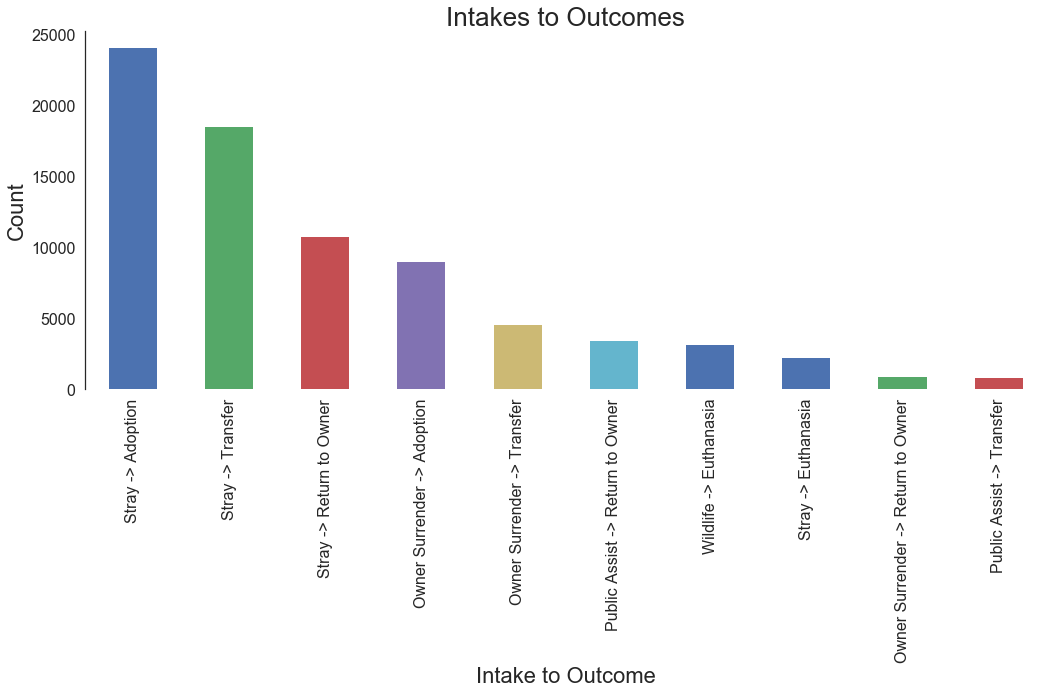

In [26]:
in_out['Intake_Outcome'] = in_out['intake_type'] + ' -> ' + in_out['outcome_type']

intake_outcomes = in_out['Intake_Outcome'].value_counts()[0:10].plot(kind='bar', 
                                                                     fontsize=16, 
                                                                     figsize=(15, 10))
intake_outcomes.set_ylabel('Count', fontsize=22)
intake_outcomes.set_xlabel('Intake to Outcome', fontsize=22)
intake_outcomes.set_title('Intakes to Outcomes', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

As we suspected, stray intakes to adoption or transfer outcome are the majority of cases in the data, followed by lost animals being returned to their owners `(Stray -> Return to Owner)` and pets being surrendered by their owners and later adopted `(Owner Surrender -> Adoption).` Judging from the above plot, it appears the first few intakes to outcome paths represent the majority of overall cases, but we can quickly find the cumulative proportion of the intake to outcome paths with a quick and dirty loop.

In [27]:
for i in range(1, 10):
    print(in_out['Intake_Outcome'].value_counts()[0:i].sum() / in_out['Intake_Outcome'].value_counts().sum())

0.3011975596896889
0.5331525696065879
0.6669302804348372
0.7793803821144335
0.8361326604905727
0.8779342723004695
0.9162837990509904
0.9432853807335995
0.9533027039240792


The reported cumulative proportions show the first ten intake to outcome paths regarding overall volume represent about 95% of all cases. Stray intakes to adoptions or transfers alone make up just over half of all animal records. Now that we know more about the volume and types of intakes to outcomes that appear at the shelter, we can turn our attention to finding out which intakes stay in the shelter the longest and the common outcome. The following groups the intakes and outcome results by the mean number of days in the shelter. 

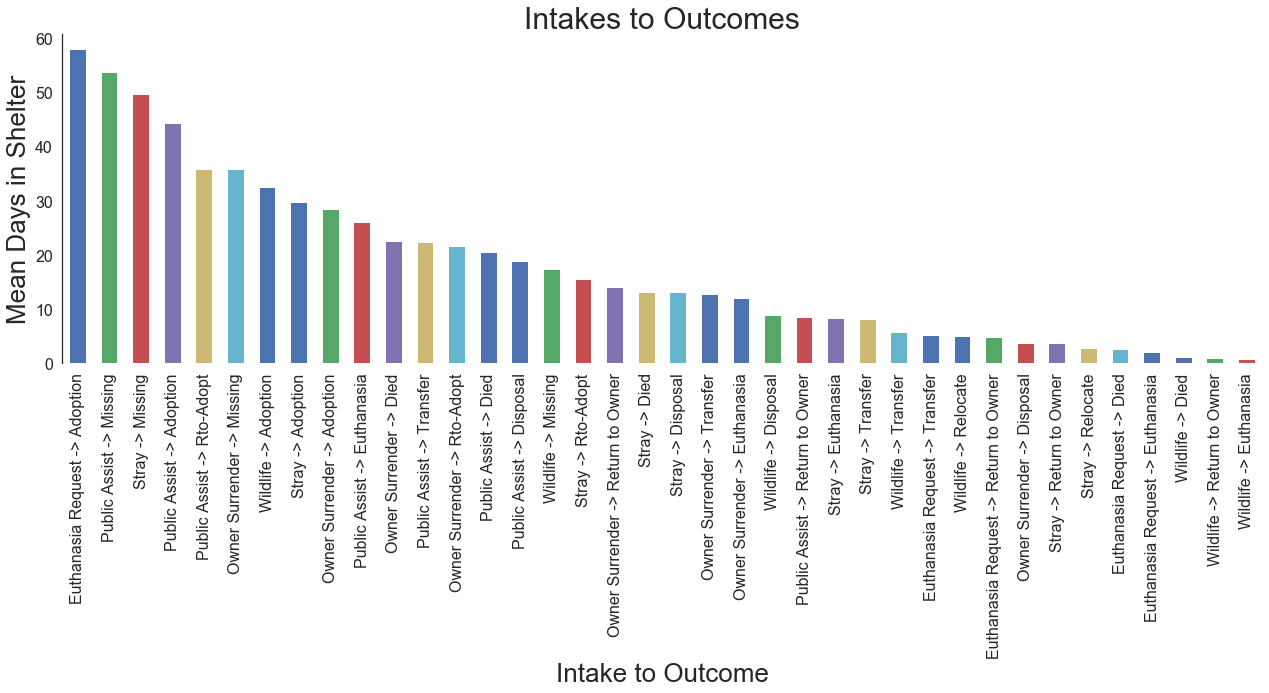

In [28]:
intake_outcome_days = in_out.groupby('Intake_Outcome')['time_in_shelter_days'].mean().sort_values(ascending=False).plot(kind='bar', 
                                                                                                                        fontsize=16, 
                                                                                                                        figsize=(18, 10))

intake_outcome_days.set_ylabel('Mean Days in Shelter', fontsize=26)
intake_outcome_days.set_xlabel('Intake to Outcome', fontsize=26)
intake_outcome_days.set_title('Intakes to Outcomes', fontsize=30)

plt.tight_layout()
sns.despine(bottom=True)

Missing outcome cases and euthanasia requests to adoptions appear to take the longest to resolve on average. Stray and wildlife intakes, as well as owner surrenders that end up in adoptions,  take approximately one month, or about 30 days. As shelters are often short on space for animals and resources in general, knowing the average amount of time an animal may be in the shelter before its outcome can be valuable information for keeping overflow under control. 

In the outcomes analysis, we noted that an intact animal (not spayed or neutered) would not be adopted before being altered to help keep the animal population down. It was assumed that transfer outcomes represented intact animal intakes being transferred to a different facility to be spayed or neutered. Now that we have the intake sex and outcome sex data resulting from the combination of the two datasets, we can see if this assumption was accurate. The following plots the top 15 intake to outcome cases concerning overall volume, which we saw earlier makes up over 95% of all cases, by the animal's intact status upon intake and outcome.

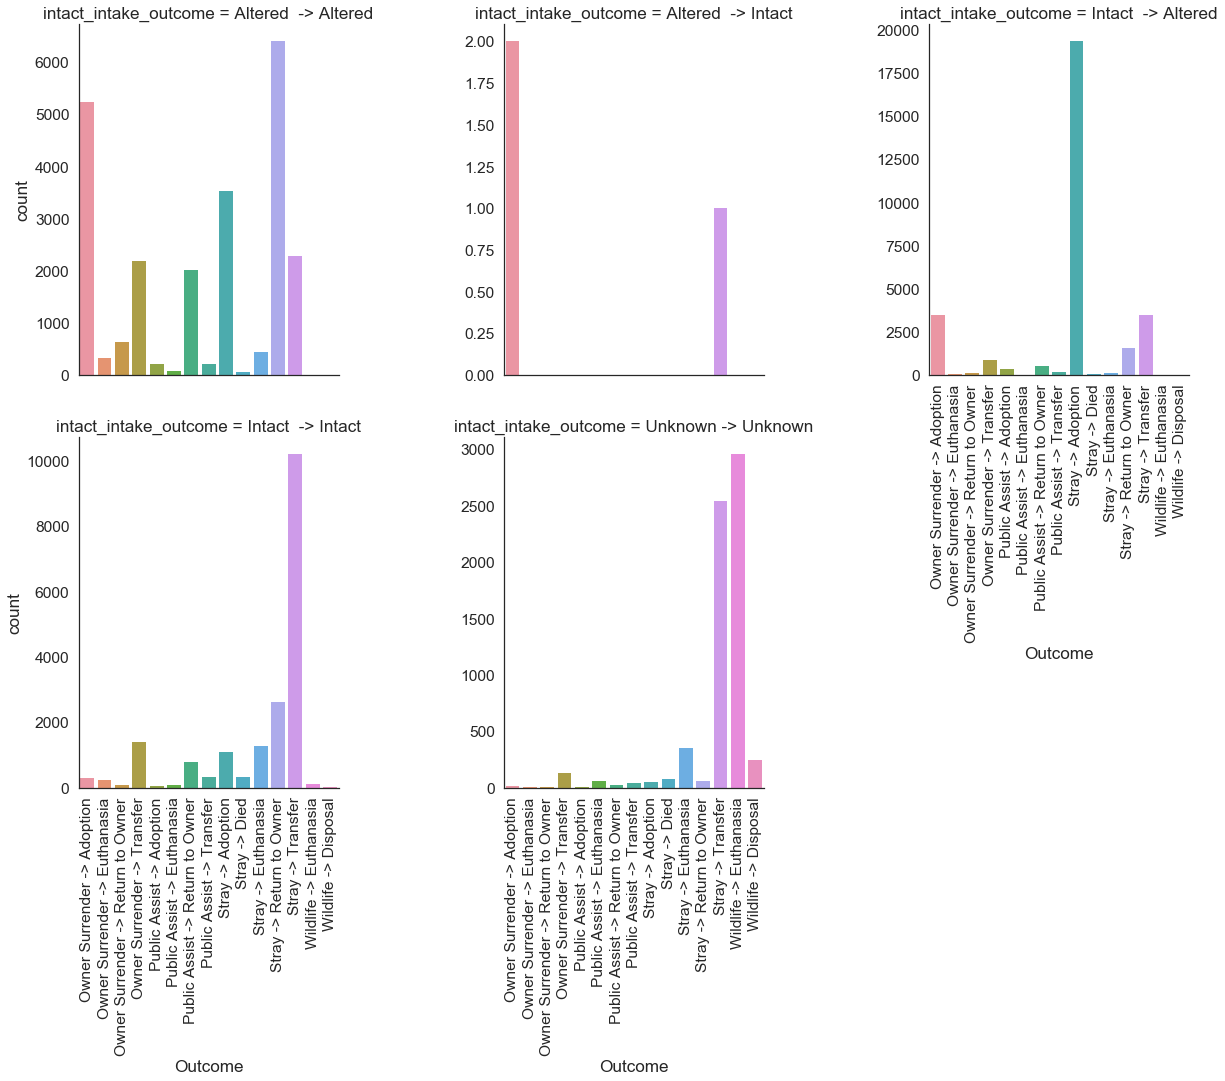

In [29]:
in_out['intact_intake_outcome'] = in_out['sex_upon_intake'] + ' -> ' + in_out['sex_upon_outcome']

in_out['intact_intake_outcome'] = in_out['intact_intake_outcome'].str.replace('Neutered|Spayed', 'Altered').str.strip()
in_out['intact_intake_outcome'] = in_out['intact_intake_outcome'].str.replace('Male|Female', '').str.strip()

top_outcomes = in_out.loc[in_out['Intake_Outcome'].isin(in_out['Intake_Outcome'].value_counts()[0:15].index)]

top_outcomes_sex = top_outcomes.groupby(['intact_intake_outcome', 
                                        'Intake_Outcome'])['count'].sum().reset_index()

plt.tight_layout()
sns.despine(bottom=True)

fact = sns.factorplot(x='Intake_Outcome', y='count', col='intact_intake_outcome', 
               kind='bar', sharey=False, col_wrap=3, size=6, data=top_outcomes_sex, ci=None)

fact.set_xticklabels(rotation=90)
fact.set_xlabels('Outcome')

First, it appears there are a few records that may be mislabeled, as the intake status is altered, but the outcome is intact, which would imply the spay or neuter operation was somehow reversed. Fortunately, however, this mislabeling appears only in four cases. As we can see from the `Intact -> Altered` bar plot, by far the most common intake to outcome is a stray intake to adoption, which shows that the animal is spayed or neutered without being transferred. This result indicates that our original assumption of intact animals being transported to partner facilities before being adopted was incorrect and that spays or neuters do occur on-site before adoption. The majority of altered animal intake to outcomes are either owners surrendering their pets to the shelter or the shelter returning a missing pet to its owner, followed by already altered strays being adopted. 

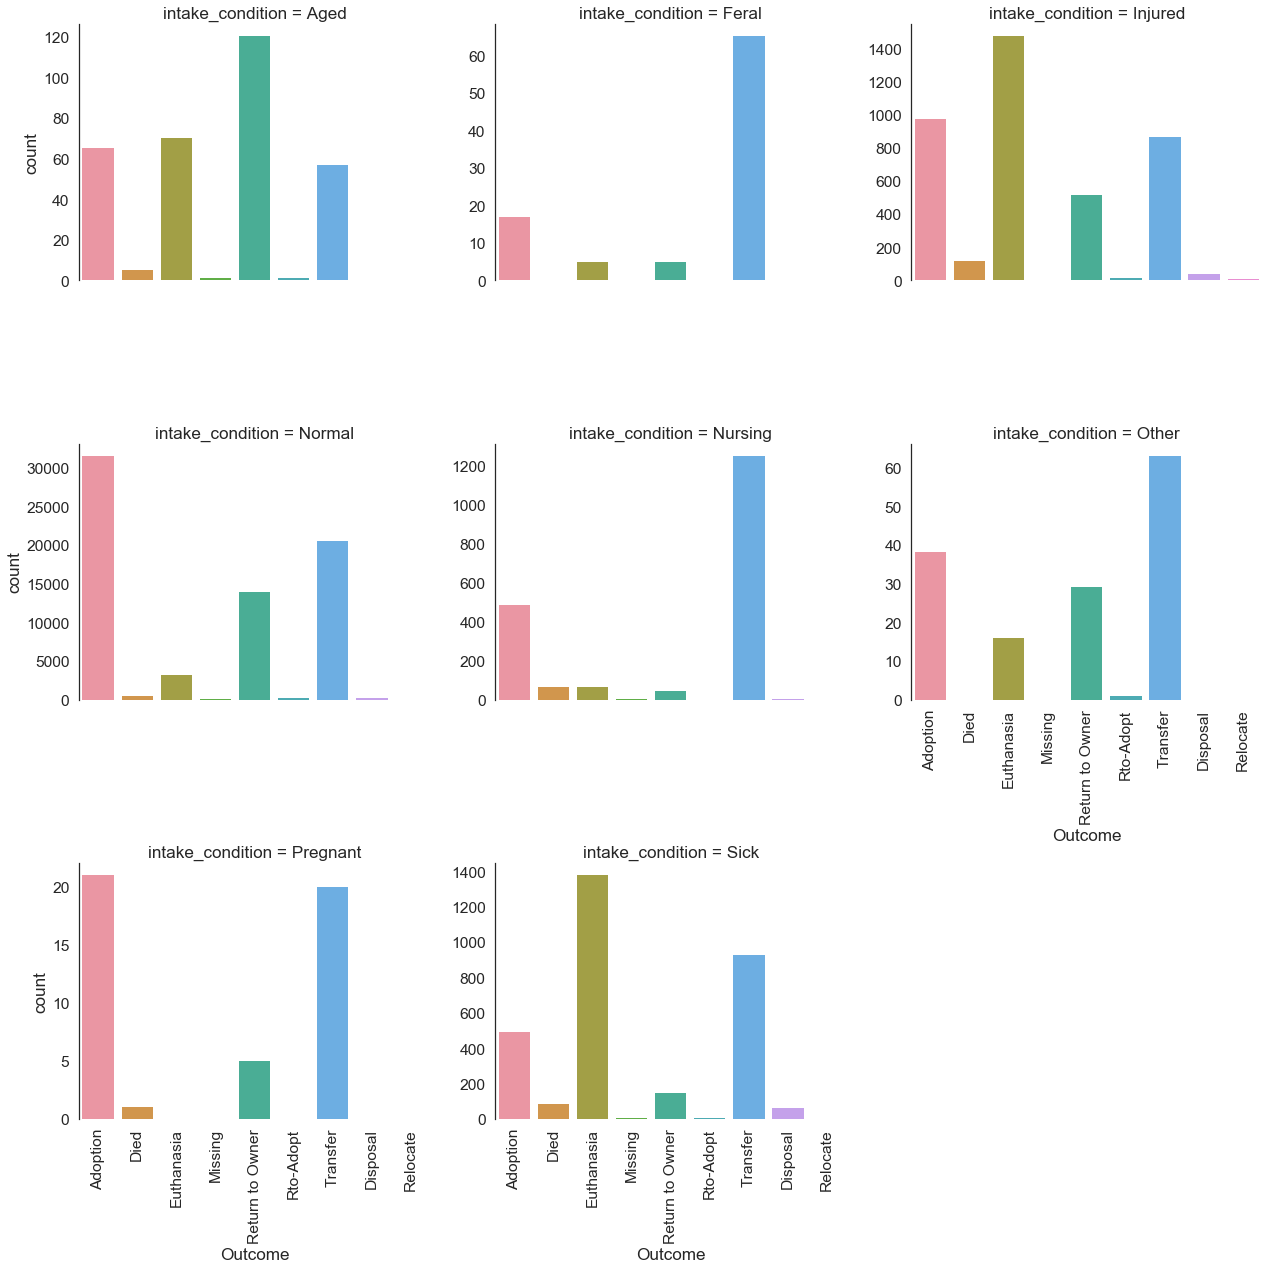

In [30]:
in_out['intake_cond_outcome'] = in_out['intake_condition'] + ' -> ' + in_out['outcome_type']
intake_cond_out = in_out.groupby(['intake_condition', 'outcome_type'])['count'].sum().reset_index()

g = sns.factorplot(x='outcome_type', y='count', col='intake_condition', 
                   col_wrap=3, kind='bar', size=6, sharey=False, data=intake_cond_out)

g.set_xticklabels(rotation=90)
g.set_xlabels('Outcome')

plt.tight_layout()
sns.despine(bottom=True)

Feral and nursing animals are mostly transferred to other facilities, while pregnant animals are likely to be adopted or transferred. The shelter would likely want to adopt a pregnant pet to an owner who is willing to take care of the resulting offspring rather than further burden any of the shelter's partner facilities. About 50% of sick animals entering the shelter needed to be euthanized, however, the remaining 50% are either transferred or adopted. It is possible the animal will still need to be euthanized after being moved, but hopefully, the partner facility will have the resources to administer more effective care. Injured animals are also often euthanized, suggesting the injury is severe, and euthanasia was, unfortunately, the best course of action. However, injured animals are also often adopted or returned to their owner at a seemingly higher proportion than sick animals, implying the animal has or will recover from its injury.

Does the condition of the animal upon intake help determine how long an animal may need to stay at the shelter? One would assume that sick or injured animals may need to stay longer to convalesce and that older animals may remain in the shelter for more days on average before being adopted.

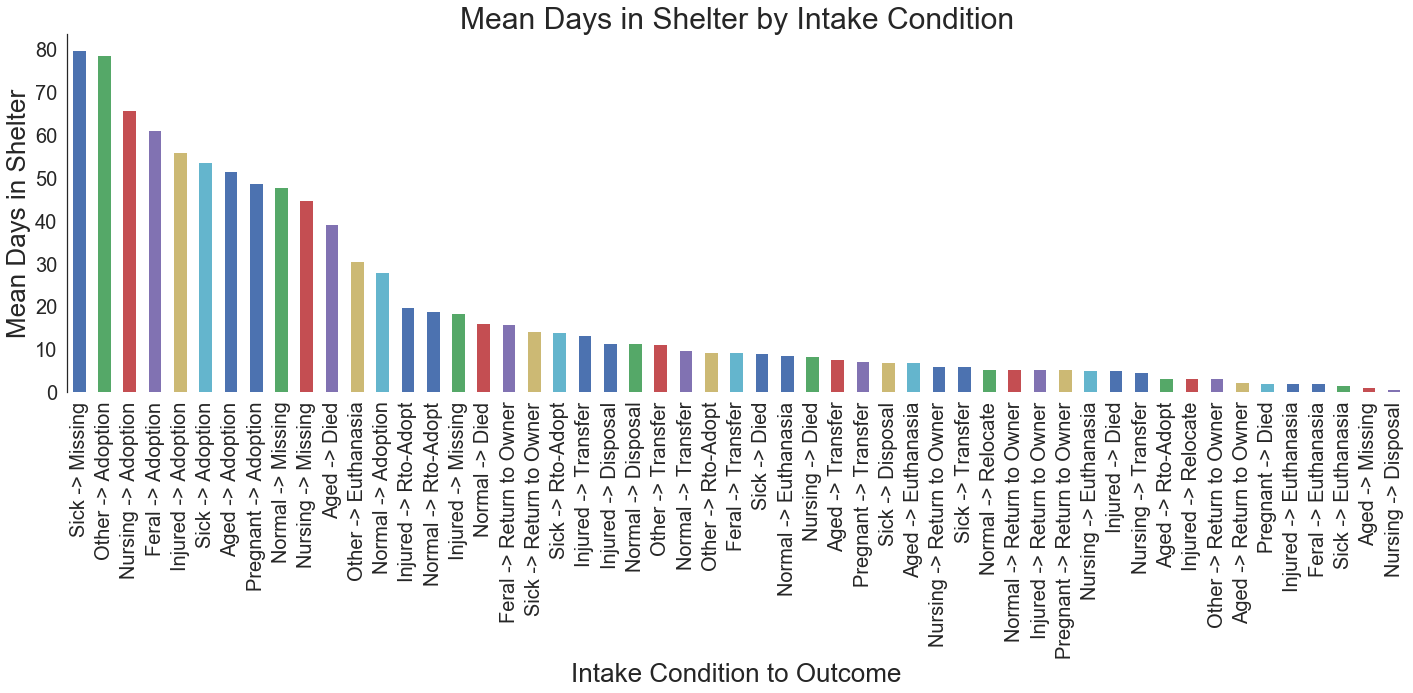

In [31]:
intake_cond_out_time = in_out.groupby(['intake_cond_outcome'])['time_in_shelter_days'].mean().sort_values(ascending=False).plot(kind='bar', 
                                                                                                                                figsize=(20, 10),
                                                                                                                                fontsize=20)
intake_cond_out_time.set_ylabel('Mean Days in Shelter', fontsize=26)
intake_cond_out_time.set_xlabel('Intake Condition to Outcome', fontsize=26)
intake_cond_out_time.set_title('Mean Days in Shelter by Intake Condition', fontsize=30)

plt.tight_layout()
sns.despine(bottom=True)

Most non-normal intake conditions that eventually lead to an adoption appear to take the most days on average, ranging anywhere from about 50 to 60 days. Animals that go missing from the shelter also seem to take the longest to resolve on average. Although it's unclear how an animal would go missing from the shelter, the length of time between the intake and the missing outcome is likely the amount of time the staff keeps a search for the animal before it receives the 'Missing' outcome categorization.

## Conclusion

Through the combination of the Austin Animal Center's intakes and outcomes datasets and some cleaning and feature engineering of the data, we were able to investigate further into the complete process from the animal's intake into its outcome. By performing exploratory data analysis on the merged and transformed dataset, we revealed several exciting pieces of information that gives us more knowledge of what to expect when an animal arrives at the shelter regarding the time of stay and possible outcomes. This information will be of critical value when building and validating prediction models as we have prior knowledge of the factors and other components of the data that appear to have importance in predicting the animal's length of stay in the shelter or its outcome.

In [32]:
in_out = in_out.loc[:,:'time_in_shelter_days']
in_out.to_csv('../../../datasets/austin animal center intake outcomes/aac_intakes_outcomes.csv', 
              encoding='utf-8', index=False)